In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system =

In [56]:
import pandas as pd
import numpy as np
import re
import nltk
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
     DataCollatorWithPadding
)
from datasets import Dataset
from peft import get_peft_model, LoraConfig, TaskType
import warnings
import tqdm
warnings.filterwarnings('ignore')

In [3]:
# تحميل موارد NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [6]:

data = pd.read_csv("Womens Clothing E-Commerce Reviews.csv")

In [7]:
# إنشاء عمود المشاعر من التقييم
def get_sentiment(rating):
    if rating >= 4:
        return 'positive'
    elif rating == 3:
        return 'neutral'
    else:
        return 'negative'

data['Sentiment'] = data['Rating'].apply(get_sentiment)

In [8]:
data

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Sentiment
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,positive
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,positive
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,neutral
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,positive
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,positive
...,...,...,...,...,...,...,...,...,...,...,...,...
23481,23481,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses,positive
23482,23482,862,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,1,0,General Petite,Tops,Knits,neutral
23483,23483,1104,31,"Cute, but see through","This fit well, but the top was very see throug...",3,0,1,General Petite,Dresses,Dresses,neutral
23484,23484,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses,neutral


In [9]:
data.isna().sum()

,0
Unnamed: 0,0
Clothing ID,0
Age,0
Title,3810
Review Text,845
Rating,0
Recommended IND,0
Positive Feedback Count,0
Division Name,14
Department Name,14


In [10]:
# معالجة النصوص
data['Review Text'] = data['Review Text'].fillna('mode')
data['Title'] = data['Title'].fillna('mode')
data['Division Name'] = data['Division Name'].fillna('mode')
data['Department Name'] = data['Department Name'].fillna('mode')
data['Class Name'] = data['Class Name'].fillna('mode')

In [11]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [12]:
data['Clean_Review'] = data['Review Text'].apply(clean_text)

In [13]:

stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stop_words])

In [14]:
data['Clean_Review_No_Stop'] = data['Clean_Review'].apply(remove_stopwords)

In [41]:
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

In [43]:
data['Lemmatized_Review'] = data['Clean_Review_No_Stop'].apply(lemmatize_text)

In [18]:
# ترميز المشاعر
label_encoder = LabelEncoder()
data['Sentiment_Label'] = label_encoder.fit_transform(data['Sentiment'])

In [53]:
# تقسيم البيانات
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42, stratify=data['Sentiment_Label'])

In [54]:
# تحويل البيانات
train_dataset = Dataset.from_pandas(train_df[['Lemmatized_Review', 'Sentiment_Label']].rename(
    columns={'Lemmatized_Review': 'text', 'Sentiment_Label': 'label'}))
test_dataset = Dataset.from_pandas(test_df[['Lemmatized_Review', 'Sentiment_Label']].rename(
    columns={'Lemmatized_Review': 'text', 'Sentiment_Label': 'label'}))

In [57]:
# إعداد النموذج والمحول
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [58]:

def tokenize_function(example):
    return tokenizer(example["text"], truncation=True)

In [59]:
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/18788 [00:00<?, ? examples/s]

Map:   0%|          | 0/4698 [00:00<?, ? examples/s]

In [60]:
# تحميل النموذج الأساسي
base_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [65]:
# تكوين LoRA
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    bias="none",
    target_modules=["q_lin", "k_lin", "v_lin", "out_lin"] # Add this line
)

In [66]:
# تطبيق LoRA على النموذج
model = get_peft_model(base_model, peft_config)
model.print_trainable_parameters()


trainable params: 887,811 || all params: 67,843,590 || trainable%: 1.3086


In [80]:
# إعدادات التدريب
training_args = TrainingArguments(
    output_dir="./results-lora",
    eval_strategy="epoch", # Changed from evaluation_strategy to eval_strategy
    learning_rate=1e-4,  # تقليل معدل التعلم
    per_device_train_batch_size=32,  # زيادة حجم الدفعة
    per_device_eval_batch_size=32,
    num_train_epochs=5,  # زيادة عدد الحقبات
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    report_to="none"  # لتجنب مشاكل wandb
)

In [81]:
# تقييم النموذج
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "classification_report": classification_report(
            labels, preds, target_names=label_encoder.classes_, output_dict=True)
    }

In [82]:
# تدريب النموذج
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics,
    data_collator=data_collator  # استخدام DataCollatorWithPadding
)

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [83]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Classification Report
1,0.420000,0.435691,0.832695,"{'negative': {'precision': 0.5677966101694916, 'recall': 0.5560165975103735, 'f1-score': 0.5618448637316562, 'support': 482.0}, 'neutral': {'precision': 0.46984126984126984, 'recall': 0.2578397212543554, 'f1-score': 0.3329583802024747, 'support': 574.0}, 'positive': {'precision': 0.8938890309383789, 'recall': 0.9599121361889071, 'f1-score': 0.9257248775321064, 'support': 3642.0}, 'accuracy': 0.8326947637292464, 'macro avg': {'precision': 0.6438423036497134, 'recall': 0.591256151651212, 'f1-score': 0.6068427071554124, 'support': 4698.0}, 'weighted avg': {'precision': 0.8086229684265984, 'recall': 0.8326947637292464, 'f1-score': 0.8159679307209047, 'support': 4698.0}}"
2,0.329800,0.440128,0.833120,"{'negative': {'precision': 0.5628865979381443, 'recall': 0.5663900414937759, 'f1-score': 0.5646328852119958, 'support': 482.0}, 'neutral': {'precision': 0.4491315136476427, 'recall': 0.3153310104529617, 'f1-score': 0.3705220061412487, 'support': 574.0}, 'positive': {'precision': 0.9081364829396326, 'recall': 0.9500274574409665, 'f1-score': 0.9286097691894794, 'support': 3642.0}, 'accuracy': 0.8331204767986378, 'macro avg': {'precision': 0.6400515315084733, 'recall': 0.6105828364625681, 'f1-score': 0.6212548868475746, 'support': 4698.0}, 'weighted avg': {'precision': 0.8166338654546774, 'recall': 0.8331204767986378, 'f1-score': 0.8230799194519673, 'support': 4698.0}}"
3,0.309800,0.447914,0.833759,"{'negative': {'precision': 0.625, 'recall': 0.47717842323651455, 'f1-score': 0.5411764705882353, 'support': 482.0}, 'neutral': {'precision': 0.44315992292870904, 'recall': 0.40069686411149824, 'f1-score': 0.42086001829826164, 'support': 574.0}, 'positive': {'precision': 0.9071109944896353, 'recall': 0.9492037342119715, 'f1-score': 0.9276801288071918, 'support': 3642.0}, 'accuracy': 0.8337590464027246, 'macro avg': {'precision': 0.6584236391394481, 'recall': 0.6090263405199948, 'f1-score': 0.6299055392312295, 'support': 4698.0}, 'weighted avg': {'precision': 0.8214819152176098, 'recall': 0.8337590464027246, 'f1-score': 0.8261029668885747, 'support': 4698.0}}"
4,0.344100,0.441069,0.833120,"{'negative': {'precision': 0.5692963752665245, 'recall': 0.553941908713693, 'f1-score': 0.5615141955835962, 'support': 482.0}, 'neutral': {'precision': 0.4457593688362919, 'recall': 0.39372822299651566, 'f1-score': 0.4181313598519889, 'support': 574.0}, 'positive': {'precision': 0.9191295002686728, 'recall': 0.9393190554640307, 'f1-score': 0.9291146116241173, 'support': 3642.0}, 'accuracy': 0.8331204767986378, 'macro avg': {'precision': 0.6447284147904965, 'recall': 0.6289963957247465, 'f1-score': 0.6362533890199008, 'support': 4698.0}, 'weighted avg': {'precision': 0.8254015263024697, 'recall': 0.8331204767986378, 'f1-score': 0.8289682116563155, 'support': 4698.0}}"
5,0.287300,0.440029,0.834610,"{'negative': {'precision': 0.5951807228915663, 'recall': 0.5124481327800829, 'f1-score': 0.5507246376811594, 'support': 482.0}, 'neutral': {'precision': 0.44672897196261685, 'recall': 0.4163763066202091, 'f1-score': 0.4310189359783589, 'support': 574.0}, 'positive': {'precision': 0.9164887940234792, 'recall': 0.943163097199341, 'f1-score': 0.9296346414073072, 'support': 3642.0}, 'accuracy': 0.834610472541507, 'macro avg': {'precision': 0.6527994962925541, 'recall': 0.623995845533211, 'f1-score': 0.6371260716889419, 'support': 4698.0}, 'weighted avg': {'precision': 0.8261285070612576, 'recall': 0.834610472541507, 'f1-score': 0.8298389758661793, 'support': 4698.0}}"


TrainOutput(global_step=2940, training_loss=0.32842539638078133, metrics={'train_runtime': 417.1751, 'train_samples_per_second': 225.181, 'train_steps_per_second': 7.047, 'total_flos': 1517373217592784.0, 'train_loss': 0.32842539638078133, 'epoch': 5.0})

In [84]:
# التقييم
results = trainer.evaluate()
print("\nEvaluation Results:")
print(f"Accuracy: {results['eval_accuracy']:.4f}")

print("\nClassification Report:")
report_df = pd.DataFrame(results['eval_classification_report']).transpose()
print(report_df)


Evaluation Results:
Accuracy: 0.8346

Classification Report:
              precision    recall  f1-score     support
negative       0.595181  0.512448  0.550725   482.00000
neutral        0.446729  0.416376  0.431019   574.00000
positive       0.916489  0.943163  0.929635  3642.00000
accuracy       0.834610  0.834610  0.834610     0.83461
macro avg      0.652799  0.623996  0.637126  4698.00000
weighted avg   0.826129  0.834610  0.829839  4698.00000


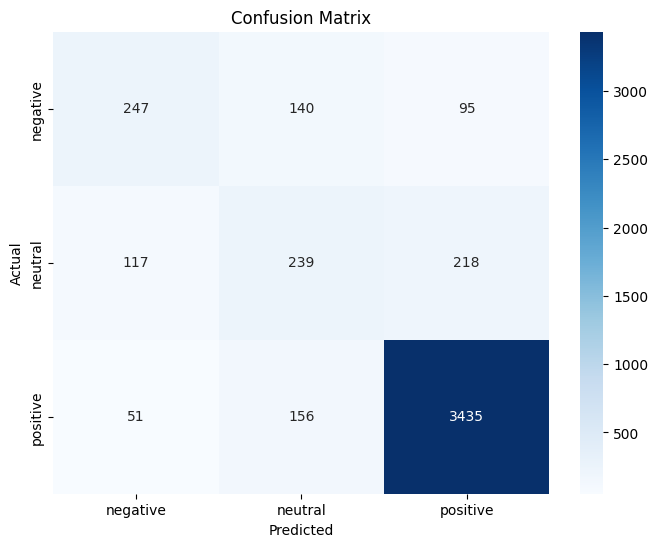

In [85]:
# مصفوفة الالتباس
predictions = trainer.predict(tokenized_test)
preds = np.argmax(predictions.predictions, axis=-1)

cm = confusion_matrix(test_dataset['label'], preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [87]:
# تجربة على نص يدوي
sample_text = "This dress is bad and fits perfectly,"
sample_input = tokenizer(sample_text, return_tensors="pt", padding=True, truncation=True)

# Move input tensors to the same device as the model
sample_input = {k: v.to(model.device) for k, v in sample_input.items()}

with torch.no_grad():
    logits = model(**sample_input).logits
predicted_class = label_encoder.inverse_transform([torch.argmax(logits).item()])[0]
print(f"\nSample Prediction: '{sample_text}'")
print(f"Predicted Sentiment: {predicted_class}")


Sample Prediction: 'This dress is bad and fits perfectly,'
Predicted Sentiment: negative
